In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('nbaallelo.csv',index_col='game_id')
df = df[df['game_location']!='A'] 

In [3]:
new_team = {
    'CHO':'CHA',
    'NOP':'NOH',
    'BRK':'NJN',
    'OKC':'SEA',
    'NOK':'NOH',
    'NOH':'CHH',
    'MEM':'VAN',
    'WAS':'WSB',
    'SAC':'KCK',
    'LAC':'SDC',
    'UTA':'NOJ',
    'SDC':'BUF',
    'NJN':'NYN',
    'GSW':'SFW',
    'DLC':'TEX',
    'HOU':'SDR',
    'CHA':'CHH',
    'SAA':'TEX',
    'SAS':'SAA',
    'DEN':'DNA',
    'DNA':'DNR',
    'WSB':'CAP',
    'CAP':'BAL',
    'BAL':'CHZ',
    'CHZ':'CHP',
    'SDS':'SDA',
    'FLO':'MMF',
    'MMF':'MNM',
    'SFW':'PHW',
    'LAL':'MNL',
    'LAS':'ANA',
    'UTS':'LAS',
    'CAR':'HSM',
    'SSL':'CAR',
    'DET':'FTW',
    'MLH':'TRI',
    'STL':'MLH',
    'ATL':'STL',
    'PHI':'SYR',
    'CIN':'ROC',
    'PTC':'PTP',
    'MNP':'PTP',
    'PTP':'MNP',
    'MMP':'NOB',
    'MMT':'MMP',
    'MMS':'MMT',
    'VIR':'WSA',
    'WSA':'OAK'
}

In [4]:
def elo_acc_poly(K=20,HFA=100,SW=0.75,ELOW=400,C1=0,C2=0,C3=0,C4=1,C5=0):
    NEW_TEAM=1300
    elo = {}
    year_id = 1947
    x1s = []
    x2s = []
    movs = []
    correct = 0
    games = 0
    for i,row in enumerate(df.itertuples()):
        #if (i%2) == 1:
        #    continue
        if row[3] != 0:
            continue
        if row[4] != year_id:
            for k in elo:
                elo[k] = SW*elo[k] + (1-SW)*1500
            year_id +=1
            teams1 = set(list(df[df.year_id == year_id-1].team_id.unique()) + list(df[df.year_id == year_id-1].opp_id.unique()))

            teams2 = set(list(df[df.year_id == year_id].team_id.unique()) + list(df[df.year_id == year_id].opp_id.unique()))
            #print(len(teams1),len(teams2))
            for t in [_ for _ in teams2 if not _ in teams1]:
                if t in new_team and not t in elo and new_team[t] in elo:
                    #print(t,new_team[t])
                    elo[t] = elo[new_team[t]]

        t1,t2=row[8],row[14]
        elo_i,elo_n = row[11],row[12]
        opp_elo_i,opp_elo_n = row[17],row[18]
        p1,p2 = row[10],row[16]
        elo1 = elo.get(t1,NEW_TEAM) + HFA
        if row[-4] == 'N':
            elo1 -= HFA
        elo2 = elo.get(t2,NEW_TEAM)

        winp = 1.0 / (np.exp(-(elo1-elo2)/ELOW) + 1)

        mov = abs(p1-p2)
        elo_diff_w  = (elo2 - elo1)

        extra = (np.sqrt(mov)*C1 + mov*C2 + (mov**2)*C3)
        extra /= C4 + C5*( (elo2 - elo1) if p2 > p1 else (elo1 - elo2))
        
        if p1 > p2:
            hm,am = 1,-1
            add_t = (K + extra)*(1-winp)
        else:
            hm,am = -1,1
            add_t = (K + extra)*(winp)

        if row[-4] == 'N':
            elo[t1] = elo1 + hm*add_t
        else:
            elo[t1] = elo1 + hm*add_t - HFA

        elo[t2] = elo2 + am*add_t
        a = (winp if p1 > p2 else (1.0-winp))
        b = int((elo1 > elo2) == (p1 > p2))
        if year_id > 2004:
            correct += (b+0.1*(1-(1-a)**2))
            games += 1
        else:
            pass
            correct += 0.25*(b+0.1*(1-(1-a)**2))
            games += 0.25
    return correct/games,elo
def opt_elo_poly(x):
    #print(x*xn)
    #print(x[0])
    return 1.0-elo_acc_poly(*x[0])[0]
elo_acc_poly(29.76, 198.61, 0.50, 400.00, 5.00, -1.00, 1.00, 10.00, 0.00,  )[0],elo_acc_poly()[0]

(0.7581997184419529, 0.7437955130012255)

In [5]:
def elo_acc_pid(KP=20,KD=0,KI=0,HFA=100,SW=0.75,ELOW=400,LPF=1.0):
    NEW_TEAM=1300
    elo = {}
    iterm = {}
    dterm = {}
    year_id = 1947
    x1s = []
    x2s = []
    movs = []
    correct = 0
    games = 0
    for i,row in enumerate(df.itertuples()):
        #if (i%2) == 1:
        #    continue
        if row[3] != 0:
            continue
        if row[4] != year_id:
            iterm = {}
            dterm = {}
            for k in elo:
                elo[k] = SW*elo[k] + (1-SW)*1500
            year_id +=1
            teams1 = set(list(df[df.year_id == year_id-1].team_id.unique()) + list(df[df.year_id == year_id-1].opp_id.unique()))

            teams2 = set(list(df[df.year_id == year_id].team_id.unique()) + list(df[df.year_id == year_id].opp_id.unique()))
            #print(len(teams1),len(teams2))
            for t in [_ for _ in teams2 if not _ in teams1]:
                if t in new_team and not t in elo and new_team[t] in elo:
                    #print(t,new_team[t])
                    elo[t] = elo[new_team[t]]
  


        t1,t2=row[8],row[14]
        elo_i,elo_n = row[11],row[12]
        opp_elo_i,opp_elo_n = row[17],row[18]
        p1,p2 = row[10],row[16]
        elo1 = elo.get(t1,NEW_TEAM) + HFA
        if row[-4] == 'N':
            elo1 -= HFA
        elo2 = elo.get(t2,NEW_TEAM)

        winp = 1.0 / (np.exp(-(elo1-elo2)/ELOW) + 1)

        mov = abs(p1-p2)
        elo_diff_w  = (elo2 - elo1)

        if p1 > p2:
            hm,am = 1,-1
            add_t = (1-winp)
        else:
            hm,am = -1,1
            add_t = (winp)

        #print(mofv_m,mov)
        if row[-4] == 'N':
            elo[t1] = elo1 + KP*hm*add_t + KD*(hm*add_t - dterm.get(t1,hm*add_t)) + KI*iterm.get(t1,0)
        else:
            elo[t1] = elo1 + KP*hm*add_t - HFA + KD*(hm*add_t - dterm.get(t1,hm*add_t)) + KI*iterm.get(t1,0)

        elo[t2] = elo2 + KP*am*add_t + KD*(am*add_t - dterm.get(t2,am*add_t)) + KI*iterm.get(t2,0)
        dterm[t1] = LPF*hm*add_t + (1-LPF)*dterm.get(t1,hm*add_t)
        dterm[t2] = LPF*am*add_t + (1-LPF)*dterm.get(t2,am*add_t)
        iterm[t1] = iterm.get(t1,0) + hm*add_t
        iterm[t2] = iterm.get(t2,0) + am*add_t
        a = (winp if p1 > p2 else (1.0-winp))
        b = int((elo1 > elo2) == (p1 > p2))
        if year_id > 2004:
            #a = a ** (1/3)
            correct += (b+0.1*(1-(1-a)**2))
            games += 1
        else:
            #pass
            correct += 0.25*(b+0.1*(1-(1-a)**2))
            games += 0.25* 1.0
        #print(elo1,elo2)
        #print(p1,p2)
        #print(winp)
    return correct/games,elo
def opt_elo_pid(x):
    #print(x*xn)
    #print(x[0])
    return 1.0-elo_acc_pid(*x[0])[0]
elo_acc_pid(120.05, 7.21, 0.17, 247.69, 0.70, 400.00, 0.94, )[0],elo_acc_pid(81.41230187,   0.        ,   0.        , 241.40955643,       0.5       , 465.8921979)[0]

(0.751568918977521, 0.7557074001449813)

In [6]:
def elo_acc_simple(K=20,HFA=100,SW=0.75,ELOW=400): # 173.71
    NEW_TEAM=1300
    elo = {}
    year_id = 1947
    x1s = []
    x2s = []
    movs = []
    correct = 0
    games = 0
    for i,row in enumerate(df.itertuples()):
        #if (i%2) == 1:
        #    continue
        if row[3] != 0:
            continue
        if row[4] != year_id:
            for k in elo:
                elo[k] = SW*elo[k] + (1-SW)*1500
            year_id +=1
            teams1 = set(list(df[df.year_id == year_id-1].team_id.unique()) + list(df[df.year_id == year_id-1].opp_id.unique()))

            teams2 = set(list(df[df.year_id == year_id].team_id.unique()) + list(df[df.year_id == year_id].opp_id.unique()))
            #print(len(teams1),len(teams2))
            for t in [_ for _ in teams2 if not _ in teams1]:
                if t in new_team and not t in elo and new_team[t] in elo:
                    #print(t,new_team[t])
                    elo[t] = elo[new_team[t]]

        t1,t2=row[8],row[14]
        elo_i,elo_n = row[11],row[12]
        opp_elo_i,opp_elo_n = row[17],row[18]
        p1,p2 = row[10],row[16]
        elo1 = elo.get(t1,NEW_TEAM) + HFA
        if row[-4] == 'N':
            elo1 -= HFA
        elo2 = elo.get(t2,NEW_TEAM)

        winp = 1.0 / (np.exp(-(elo1-elo2)/ELOW) + 1)

        mov = abs(p1-p2)
        elo_diff_w  = (elo2 - elo1)

        if p1 > p2:
            hm,am = 1,-1
            add_t = K*(1-winp)
        else:
            hm,am = -1,1
            add_t = K*(winp)

        #print(mofv_m,mov)
        if row[-4] == 'N':
            elo[t1] = elo1 + hm*add_t
        else:
            elo[t1] = elo1 + hm*add_t - HFA

        elo[t2] = elo2 + am*add_t
        a = (winp if p1 > p2 else (1.0-winp))
        b = int((elo1 > elo2) == (p1 > p2))
        if year_id > 2004:
            #a = a ** (1/3)
            correct += (b+0.1*(1-(1-a)**2))
            games += 1
        else:
            pass
            #a = a ** (1/3)
            correct += 0.25*(b+0.1*(1-(1-a)**2))
            games += 0.25
        #print(elo1,elo2)
        #print(p1,p2)
        #print(winp)
    return correct/games,elo
def opt_elo_simple(x):
    #print(x*xn)
    #print(x[0])
    return 1.0-elo_acc_simple(*x[0])[0]
elo_acc_simple()[0],elo_acc_simple( 70.76, 208.57, 0.50, )[0]

(0.7437955130012255, 0.7557618558080772)

In [33]:
def elo_acc(K=20,HFA=100,SW=0.75,MOVM=3,ELOW=400):
    INTERCEPT=7.5
    SLOPE=0.006
    POW=0.8
    NEW_TEAM=1300
    elo = {}
    year_id = 1947
    ELOW=400
    x1s = []
    x2s = []
    movs = []
    correct = 0
    games = 0
    for i,row in enumerate(df.itertuples()):
        #if (i%2) == 1:
        #    continue
        if row[3] != 0:
            continue
        if row[4] != year_id:
            for k in elo:
                elo[k] = SW*elo[k] + (1-SW)*1505
            year_id +=1
            teams1 = set(list(df[df.year_id == year_id-1].team_id.unique()) + list(df[df.year_id == year_id-1].opp_id.unique()))

            teams2 = set(list(df[df.year_id == year_id].team_id.unique()) + list(df[df.year_id == year_id].opp_id.unique()))
            #print(len(teams1),len(teams2))
            for t in [_ for _ in teams2 if not _ in teams1]:
                if t in new_team and not t in elo and new_team[t] in elo:
                    #print(t,new_team[t])
                    elo[t] = elo[new_team[t]]

        t1,t2=row[8],row[14]
        elo_i,elo_n = row[11],row[12]
        opp_elo_i,opp_elo_n = row[17],row[18]
        p1,p2 = row[10],row[16]
        elo1 = elo.get(t1,NEW_TEAM) + HFA
        if row[-4] == 'N':
            elo1 -= HFA
        elo2 = elo.get(t2,NEW_TEAM)
        #if t1 not in elo:
        #    print(t1,row[9],len(elo),year_id)
        #if t2 not in elo:
        #    print(t2,row[15],len(elo),year_id)
        winp = 1.0 / (10 ** (-(elo1-elo2)/ELOW) + 1)

        mov = abs(p1-p2)
        elo_diff_w  = (elo2 - elo1)
        mofv_m1 = ((mov+MOVM) ** POW)/(INTERCEPT + SLOPE*(-elo_diff_w))
        mofv_m2 = ((mov+MOVM) ** POW)/(INTERCEPT + SLOPE*(elo_diff_w))

        if p1 > p2:
            hm,am = 1,-1
            add_t = K*(1-winp)*mofv_m1
        else:
            hm,am = -1,1
            add_t = K*(winp)*mofv_m2

        #print(mofv_m,mov)
        if row[-4] == 'N':
            elo[t1] = elo1 + hm*add_t
        else:
            elo[t1] = elo1 + hm*add_t - HFA

        elo[t2] = elo2 + am*add_t
        a = (winp if p1 > p2 else (1.0-winp))
        b = int((elo1 > elo2) == (p1 > p2))
        if year_id > 2004:
            #a = a ** (1/3)
            correct += (b+0.1*(1-(1-a)**2))
            games += 1
        else:
            pass
            #a = a ** (1/3)
            correct += 0.25*(b+0.1*(1-(1-a)**2))
            games += 0.25
        #print(elo1,elo2)
        #print(p1,p2)
        #print(winp)
    return correct/games,elo
def opt_elo(x):
    #print(x*xn)
    #print(x[0])
    return 1.0-elo_acc(*x[0])[0]
elo_acc(20,100,0.75,3,400)[0],elo_acc(42,107,0.95,0,400)[0],elo_acc(53,155,0.95,0,400.)[0],elo_acc(22.6,81.5,0.5,0.,400.)[0],elo_acc(34,100,0.5,0.,400.)[0],elo_acc(4.        ,  81.94891483,   0.95      , 134.72834631)[0],elo_acc(34.01, 99.01, 0.50, 0.00, 400.00,  )[0]

(0.7560086644917214,
 0.7570263289129908,
 0.7550033284611638,
 0.7585252794137248,
 0.7593310220737157,
 0.7549398189059956,
 0.7595215389864719)

In [8]:
_,elo =elo_acc(20,100,0.75,3,400)
rests = []
for t in df[df.year_id == 2015].team_id.unique():
    #print(t,elo[t])
    rests.append((elo[t],t))
for s,t in sorted(rests,reverse=True):
    print('{}\t{:.2f}'.format(t,s))
_,elo=elo_acc(34,100,0.5,0.,400.)
rests = []
print('\n')
for t in df[df.year_id == 2015].team_id.unique():
    #print(t,elo[t])
    rests.append((elo[t],t))
for s,t in sorted(rests,reverse=True):
    print('{}\t{:.2f}'.format(t,s))
_,elo= elo_acc_pid(81.41230187,   0.        ,   0.        , 241.40955643,       0.5       , 465.8921979)
rests = []
print('\n')
for t in df[df.year_id == 2015].team_id.unique():
    #print(t,elo[t])
    rests.append((elo[t],t))
for s,t in sorted(rests,reverse=True):
    print('{}\t{:.2f}'.format(t,s))
_,elo =elo_acc(34,100,0.5,0.,400.)
rests = []
print('\n')
for t in df[df.year_id == 2015].team_id.unique():
    #print(t,elo[t])
    rests.append((elo[t],t))
for s,t in sorted(rests,reverse=True):
    print('{}\t{:.2f}'.format(t,s))

GSW	1823.57
SAS	1721.05
LAC	1694.63
CLE	1690.98
HOU	1654.73
MEM	1608.44
CHI	1591.14
OKC	1583.32
ATL	1580.88
POR	1556.83
DAL	1556.67
UTA	1555.38
WAS	1546.20
NOP	1526.66
BOS	1524.66
IND	1504.96
TOR	1500.49
PHO	1466.93
DET	1461.17
BRK	1457.83
MIA	1455.95
MIL	1443.36
DEN	1422.45
SAC	1418.37
CHO	1400.82
ORL	1311.98
LAL	1283.33
PHI	1276.28
MIN	1264.05
NYK	1255.78


GSW	1876.22
SAS	1755.99
CLE	1719.17
LAC	1707.60
HOU	1676.00
CHI	1615.95
MEM	1610.04
OKC	1588.58
UTA	1588.11
ATL	1577.80
WAS	1555.58
DAL	1553.97
BOS	1550.82
POR	1542.26
NOP	1526.96
IND	1508.38
TOR	1487.98
DET	1471.27
MIA	1450.30
PHO	1443.92
BRK	1438.54
MIL	1432.71
DEN	1429.60
SAC	1424.53
CHO	1374.75
ORL	1299.98
PHI	1269.37
LAL	1243.63
MIN	1217.45
NYK	1212.31


GSW	2394.99
CLE	2122.88
SAS	2021.31
HOU	2013.77
LAC	2013.59
MEM	1860.01
ATL	1756.41
CHI	1675.89
OKC	1657.50
DAL	1656.42
WAS	1624.91
NOP	1612.21
BOS	1605.86
UTA	1587.57
IND	1556.26
POR	1555.48
BRK	1497.49
TOR	1431.43
MIL	1392.71
PHO	1361.17
MIA	1354.31
DET	1324.47
DEN	1217.21


In [9]:
import GPyOpt
import GPy
#elo_acc_simple(K=20,HFA=100,SW=0.75,ELOW=400):
#bounds = [(10,60),(0,200),(0.5,0.95),(0,6),(400,400)] #normal
bounds = [(10,100),(100,300),(0.5,0.95),(150,400)] #,(200,500) #simple

#bounds = [(10,200),(-10,10),(-10,10),(0,600),(0.5,0.95),(400,400),(0,1)] #pid
#bounds = [(10,100),(50,300),(0.5,0.95),(400,400),(-5,5),(-1,1),(-1,1),(1,10),(0,1)] #poly
bounds2 = [{'name': 'var_{}'.format(i), 'type': 'continuous', 'domain': _} for i,_ in enumerate(bounds)]  # problem constraints 
myBopt = GPyOpt.methods.BayesianOptimization(f=opt_elo_simple,            # function to optimize
                                             model_type='GP',
                                             domain=bounds2,        # box-constraints of the problem
                                             initial_design_numdata=10,
                                             acquisition_type='LCB',
                                             exact_feval = True,
                                                num_cores=2,
                                                verbosity=True) # Selects the Expected improvement
max_iter = 1500     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps,verbosity=True)     

The set cost function is ignored! LCB acquisition does not make sense with cost.
num acquisition: 1, time elapsed: 1.16s
num acquisition: 2, time elapsed: 2.36s
num acquisition: 3, time elapsed: 3.53s
num acquisition: 4, time elapsed: 4.73s
num acquisition: 5, time elapsed: 6.05s
num acquisition: 6, time elapsed: 7.37s
num acquisition: 7, time elapsed: 8.59s
num acquisition: 8, time elapsed: 9.79s
num acquisition: 9, time elapsed: 11.22s
num acquisition: 10, time elapsed: 12.60s
num acquisition: 11, time elapsed: 14.01s
num acquisition: 12, time elapsed: 15.30s
num acquisition: 13, time elapsed: 16.66s
num acquisition: 14, time elapsed: 17.95s
num acquisition: 15, time elapsed: 19.29s
num acquisition: 16, time elapsed: 20.52s
num acquisition: 17, time elapsed: 21.68s
num acquisition: 18, time elapsed: 22.86s
num acquisition: 19, time elapsed: 24.21s
num acquisition: 20, time elapsed: 25.47s
num acquisition: 21, time elapsed: 26.72s
num acquisition: 22, time elapsed: 27.95s
num acquisit

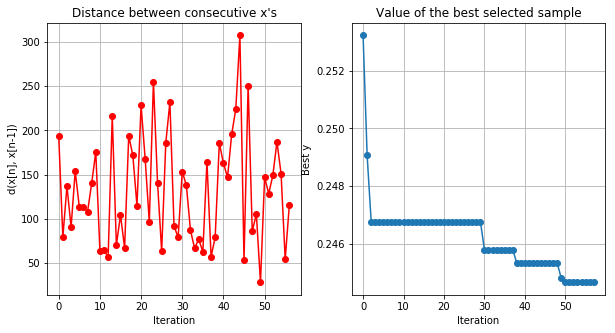

In [10]:
myBopt.plot_convergence()

In [11]:
for a in myBopt.x_opt:
    print('{:.2f},'.format(a),end=' ')
elo_acc_simple(*myBopt.x_opt)[0]

41.00, 121.67, 0.50, 226.88, 

0.755334441965373

In [12]:
df.iloc[-4:]

,gameorder,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
game_id,,,,,,,,,,,,,,,,,,,,,
201506090CLE,63154,NBA,0,2015,6/9/2015,99,1,CLE,Cavaliers,96,...,61.826408,GSW,Warriors,91,1797.5032,1790.9591,H,W,0.527843,NaN
201506110CLE,63155,NBA,0,2015,6/11/2015,100,1,CLE,Cavaliers,82,...,60.309792,GSW,Warriors,103,1790.9591,1809.9791,H,L,0.546572,NaN
201506140GSW,63156,NBA,0,2015,6/14/2015,102,1,GSW,Warriors,104,...,68.013329,CLE,Cavaliers,91,1704.3949,1700.7391,H,W,0.765565,NaN
201506170CLE,63157,NBA,0,2015,6/16/2015,102,1,CLE,Cavaliers,97,...,59.290245,GSW,Warriors,105,1813.6349,1822.2881,H,L,0.481450,NaN


In [13]:
prev_years = set()
prev_years2 = set()
if False:
    for year in sorted(df.year_id.unique()):
        teams = set(list(df[df.year_id == year].fran_id.unique()) + list(df[df.year_id == year].opp_fran.unique()))
        teams2 = set(list(df[df.year_id == year].team_id.unique()) + list(df[df.year_id == year].opp_id.unique()))

        if year > 1947:
            for t in prev_years:
                if not t in teams:
                    print('\t',t,year)
            for t in teams:
                if not t in prev_years:
                    print(t,year)

            for t in prev_years2:
                if not t in teams2:
                    print('\t',t,year)
            for t in teams2:
                if not t in prev_years2:
                    print(t,year) 
        prev_years = teams #prev_years.union(teams)
        prev_years2 = teams2 #prev_years2.union(teams2)

(173.71779276130073, 2.302585092994046)

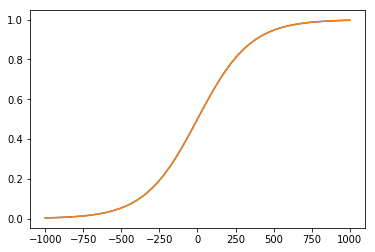

In [14]:
#plt.plot(1/(1+np.exp(-np.linspace(-10,10))))
x = np.linspace(-1000,1000)
scaled = 400/np.log(10)
plt.plot(x,1/(1+10**(-x/400)))
plt.plot(x,1/(1+np.exp(-x/scaled)))
scaled,np.log(10)

In [15]:
from collections import defaultdict
# B. Morris says logistic regression does better, let's see! 
Xd = []
yd = []
movs = defaultdict(list)
season_averages = {}
previous_season_average = {}
year_id = 1947
for i,row in enumerate(df.itertuples()):
    # duplicate
    if row[3] != 0:
        continue
    # new year
    if row[4] != year_id:
        year_id +=1
        teams1 = set(list(df[df.year_id == year_id-1].team_id.unique()) + list(df[df.year_id == year_id-1].opp_id.unique()))
        teams2 = set(list(df[df.year_id == year_id].team_id.unique()) + list(df[df.year_id == year_id].opp_id.unique()))
        previous_season_average = season_averages
        season_averages = {}
        movs = defaultdict(list)
        for t in [_ for _ in teams2 if not _ in teams1]:
            if t in new_team and not t in previous_season_average and new_team[t] in previous_season_average:
                previous_season_average[t] = previous_season_average[new_team[t]]

    t1,t2=row[8],row[14]
    elo_i,elo_n = row[11],row[12]
    opp_elo_i,opp_elo_n = row[17],row[18]
    p1,p2 = row[10],row[16]
    t1s = season_averages.get(t1,[])
    t2s = season_averages.get(t2,[])
    pt1s = previous_season_average.get(t1,[])
    pt2s = previous_season_average.get(t2,[])
    t1m = movs[t1]
    t2m = movs[t2]
    
    mov = p1 - p2
    wp1 = sum(t1s)/np.maximum(1,len(t1s))
    wp2 = sum(t2s)/np.maximum(1,len(t2s))
    pwp1 = sum(pt1s)/np.maximum(1,len(pt1s))
    pwp2 = sum(pt2s)/np.maximum(1,len(pt2s))

    nr1 = sum(t1m)/np.maximum(1,len(t1m))
    nr2 = sum(t2m)/np.maximum(1,len(t2m))
    nr1r = sum(t1m[-10:])/np.maximum(1,len(t1m[-10:]))
    nr2r = sum(t2m[-10:])/np.maximum(1,len(t2m[-10:]))
    
    if mov > 0:
        t1s += [1]
        t2s += [0]
    else:
        t1s += [0]
        t2s += [1]

    season_averages[t1] = t1s
    season_averages[t2] = t2s
    movs[t1].append(mov)
    movs[t2].append(-mov)
    
    yd.append(mov > 0)
    Xd.append([wp1-wp2,pwp1-pwp2,wp1,wp2,pwp1,nr1-nr2,nr1r-nr2r,nr1r,nr1,len(t1s)] + [year_id > 1980, year_id > 2000])
    
Xd[35000],yd[35000]

([0.21984126984126987,
  0.1787661406025825,
  0.3055555555555556,
  0.08571428571428572,
  0.4470588235294118,
  13.996825396825397,
  9.700000000000001,
  -3.6,
  -2.888888888888889,
  37,
  True,
  False],
 True)

In [16]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neural_network
from sklearn import ensemble

In [17]:
Xd = np.array(Xd)
yd = np.array(yd)#[:,np.newaxis]
fexp = preprocessing.PolynomialFeatures(degree=3,interaction_only=True)
scalerX = preprocessing.StandardScaler()
prescale_X = scalerX.fit_transform(Xd)
prescale_X = fexp.fit_transform(prescale_X)

In [18]:
clf = linear_model.LogisticRegression()
clf.fit(prescale_X,yd)

#clf.fit(prescale_X[:-7647],yd[:-7647])
#clf = ensemble.ExtraTreesClassifier(40,max_depth=12)
#clf.fit(Xd[:-7647],yd[:-7647])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
b = clf.predict_proba(prescale_X[-7647:])
a = clf.score(prescale_X[-7647:],yd[-7647:])

a, ((1-b[np.arange(b.shape[0]).astype(np.int),yd[-7647:].astype(np.int)])**2).mean()

(0.6796129200993853, 0.20526936475170218)

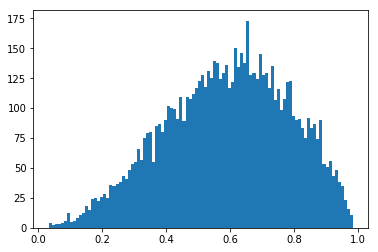

In [20]:
_ = plt.hist(b[np.arange(b.shape[0]).astype(np.int),yd[-7647:].astype(np.int)],100)

In [21]:
if False:
    import scipy.optimize as opt

    def scale_logit(s):
        b = clf.predict_proba(prescale_X[-7647:])
        xv = -np.log(1/b-1)
        b = 1/(1+np.exp(-xv*s))
        return ((1-b[np.arange(b.shape[0]).astype(np.int),yd[-7647:].astype(np.int)])**2).mean()

    res = opt.basinhopping(scale_logit,1)
    # new mean winp accuracy
    1-scale_logit(res.x),res.x[0],(b[np.arange(b.shape[0]).astype(np.int),yd[-7647:].astype(np.int)]).mean()
    # make sure the scaling produces
    b = clf.predict_proba(prescale_X[-7647:])
    xv = -np.log(1/b-1)
    b = 1/(1+np.exp(-xv*res.x))
    # same classifier!
    abs(((b > 0.5).astype(np.int)[:,0]-yd[-7647:])).mean()

In [22]:
# full data
aS = (0.59,0.61)
bS= (0.6807321437053692, 0.6818721598555979)

bSp2010 = (0.6726868210967151, 0.6779217379924094)
aSp2010 = (0.593289400989701, 0.6159781576126065)
max(bS),max(aS),max(bSp2010),max(aSp2010)

(0.6818721598555979, 0.61, 0.6779217379924094, 0.6159781576126065)

In [23]:
(0.6790898391526089, 0.5888006476797119)

(0.6790898391526089, 0.5888006476797119)

Text(0.5, 1.0, 'home team winning odds')

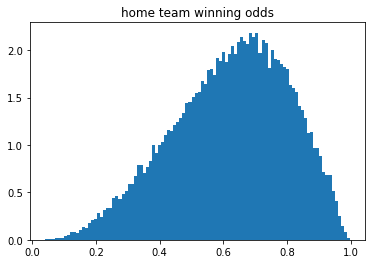

In [35]:
_ = plt.hist(b[:,1],100,density=True)
plt.title('home team winning odds')

In [25]:
MSE_ERRORS = \
(0.6073681755278523,
 0.5795554325818568,
 0.5537803066130098,
 0.6244105711098151,
 0.6031986734899218,
 0.6172620987567141)

In [26]:
w  =np.ones(yd.shape[0])
w[14220:] = 0.25
b = clf.predict_proba(prescale_X)
a = np.argmax(b,1)
1-(abs(a-yd)*w).sum()/w.sum() + 0.1 * (w*(1-b[np.arange(b.shape[0]).astype(np.int),yd.astype(np.int)]**2)).sum()/w.sum()
# (w*(1-b[np.arange(b.shape[0]).astype(np.int),yd.astype(np.int)]**2)).sum()/w.sum()


0.7436895829182865

In [27]:
1-abs(a-yd).mean()

0.6852922083062843

In [28]:
import autograd.numpy as np
import autograd
Y = yd.astype(np.float)
W = 0.1*np.random.normal(size=prescale_X.shape[1] + 1)
#W[:-1] = clf.coef_[0]
#W[-1] = clf.intercept_
INP = np.hstack([prescale_X,np.ones(prescale_X.shape[0]).reshape((-1,1))]).astype(np.float)

In [29]:
sigmoid = lambda x: 1/(1+np.exp(-x))
def loss_f(x):
    p = sigmoid(INP @ x)
    # + 
    loss = np.mean(-Y * np.log(p) - (1-Y) *np.log(1-p+1e-12)) + 0.1*((w*(((1-Y)-p)**2)).sum()/w.sum()) #+ 1e-3 * (W[:-1]**2).sum()
    return loss
GRAD = autograd.jacobian(loss_f)
loss_f(W)


1.0350892881247427

In [30]:
alpha = 1e-1
v = np.zeros_like(W)
for i in range(100):
    loss = loss_f(W)
    v = 0.9*v - GRAD(W)
    W += (alpha) * v
    if (i%1000== 0):
        alpha /= 10
    print(loss)

1.0350892881247427
0.9178815466909324
0.9079203009761472
0.8933597844672584
0.8758129254768904
0.8575884343424828
0.8413550903230931
0.8292363786130902
0.8211568873979533
0.8147843932293043
0.807338796855311
0.7974232008461853
0.7857813027517278
0.7744246246720858
0.7649528681339
0.7577041693271827
0.7518940369919435
0.7463513339808296
0.7402239874699894
0.7332906488410112
0.7259507886041062
0.7190227202836951
0.7134181550180868
0.709540150143826
0.7069846195166292
0.7044814225284902
0.7011328524887118
0.6972704957456461
0.6939811683103212
0.6918867041621474
0.6906151607175691
0.6893469748434569
0.6875057250565451
0.6850365002699825
0.682355148326401
0.6800415888466406
0.678383319987285
0.6770983265168375
0.6756774226843685
0.6740206148980257
0.6724650253852038
0.6712912740473075
0.6704200188710538
0.669550007852339
0.668467114534509
0.6672069829558335
0.6659844459508923
0.664982053500377
0.6641852529885083
0.6633983827643423
0.6625016575954109
0.6616077706204299
0.6608758491638154
0.6

0.6300044298287791
0.6299988285180173
0.6299932590010996
0.6299877210180402
0.6299822143116095
0.6299767386272975
0.6299712937132794
0.6299658793203805
0.6299604952020413
0.6299551411142849
0.6299498168156816
0.6299445220673187
0.6299392566327658
0.6299340202780451
0.6299288127715984
0.629923633884257
0.6299184833892119
0.629913361061982
0.6299082666803871
0.6299032000245169
0.6298981608767037
0.6298931490214931
0.6298881642456169
0.6298832063379662
0.6298782750895635
0.629873370293537
0.6298684917450933
0.6298636392414934
0.6298588125820258
0.629854011567982
0.6298492360026322
0.6298444856912003
0.6298397604408408
0.6298350600606145
0.6298303843614659
0.6298257331561995
0.6298211062594581
0.6298165034876999
0.6298119246591766
0.6298073695939124
0.6298028381136823
0.6297983300419903
0.6297938452040507
0.6297893834267655
0.6297849445387055
0.62978052837009
0.6297761347527681
0.6297717635201983
0.6297674145074296
0.6297630875510837
0.629758782489336
0.6297544991618965
0.6297502374099936


0.6289251028072835
0.6289240257708762
0.628922951483316
0.6289218799338409
0.6289208111117459
0.6289197450063819
0.6289186816071559
0.6289176209035315
0.6289165628850265
0.6289155075412142
0.6289144548617227
0.6289134048362341
0.6289123574544846
0.6289113127062638
0.6289102705814147
0.6289092310698333
0.6289081941614685
0.6289071598463203
0.6289061281144419
0.6289050989559375
0.6289040723609624
0.6289030483197235
0.6289020268224776
0.6289010078595325
0.628899991421245
0.6288989774980225
0.6288979660803216
0.6288969571586472
0.6288959507235543
0.6288949467656448
0.6288939452755703
0.6288929462440285
0.6288919496617661
0.6288909555195764
0.6288899638082996
0.6288889745188229
0.6288879876420791
0.6288870031690482
0.6288860210907549
0.6288850413982701
0.6288840640827097
0.6288830891352345
0.6288821165470497
0.6288811463094054
0.6288801784135956
0.6288792128509577
0.6288782496128738
0.6288772886907678
0.6288763300761077
0.6288753737604038
0.6288744197352092
0.6288734679921187
0.628872518522

0.6287819768422018
0.6287819029952383
0.6287818291635319
0.6287817553470776
0.6287816815458708
0.6287816077599069
0.628781533989181
0.6287814602336884
0.6287813864934244
0.6287813127683844
0.6287812390585635
0.6287811653639571
0.6287810916845605
0.6287810180203689
0.6287809443713774
0.6287808707375822
0.6287807971189774
0.6287807235155589
0.6287806499273221
0.6287805763542619
0.6287805027963739
0.6287804292536534
0.6287803557260957
0.628780282213696
0.6287802087164497
0.6287801352343521
0.6287800617673984
0.6287799883155842
0.6287799148789047
0.6287798414573549
0.6287797680509307
0.628779694659627
0.6287796212834391
0.6287795479223627
0.6287794745763927
0.6287794012455248
0.6287793279297541
0.6287792546290764
0.6287791813434861
0.6287791080729792
0.6287790348175513
0.628778961577197
0.6287788883519123
0.6287788151416923
0.628778741946532
0.6287786687664276
0.6287785956013737
0.628778522451366
0.6287784493163998
0.6287783761964703
0.6287783030915731
0.6287782300017034
0.6287781569268567

0.6287510291330727
0.6287509615424451
0.6287508939651816
0.6287508264012777
0.6287507588507297
0.6287506913135337
0.6287506237896856
0.6287505562791817
0.6287504887820179
0.6287504212981903
0.628750353827695
0.628750286370528
0.6287502189266855
0.6287501514961634
0.6287500840789577
0.6287500166750649
0.6287499492844807
0.6287498819072013
0.6287498145432229
0.6287497471925414
0.6287496798551527
0.6287496125310534
0.6287495452202392
0.6287494779227063
0.6287494106384508
0.6287493433674687
0.6287492761097564
0.6287492088653095
0.6287491416341245
0.6287490744161974
0.6287490072115244
0.6287489400201011
0.6287488728419242
0.6287488056769897
0.6287487385252932
0.6287486713868313
0.6287486042616003
0.6287485371495957
0.6287484700508139
0.628748402965251
0.6287483358929034
0.6287482688337668
0.6287482017878374
0.6287481347551114
0.628748067735585
0.6287480007292542
0.628747933736115
0.6287478667561642
0.6287477997893971
0.6287477328358101
0.6287476658953994
0.628747598968161
0.6287475320540913

0.6287332021582999
0.6287331957519277
0.6287331893456786
0.6287331829395528
0.6287331765335501
0.6287331701276709
0.6287331637219148
0.628733157316282
0.6287331509107722
0.6287331445053859
0.6287331381001225
0.6287331316949828
0.6287331252899657
0.6287331188850722
0.6287331124803017
0.6287331060756547
0.6287330996711306
0.6287330932667299
0.6287330868624523
0.6287330804582979
0.6287330740542666
0.6287330676503586
0.6287330612465738
0.6287330548429121
0.6287330484393736
0.6287330420359583
0.6287330356326659
0.6287330292294969
0.6287330228264512
0.6287330164235283
0.6287330100207286
0.6287330036180523
0.6287329972154989
0.6287329908130688
0.6287329844107616
0.6287329780085779
0.628732971606517
0.6287329652045793
0.6287329588027648
0.6287329524010733
0.628732945999505
0.6287329395980598
0.6287329331967378
0.6287329267955387
0.6287329203944627
0.6287329139935101
0.6287329075926802
0.6287329011919736
0.6287328947913902
0.6287328883909297
0.6287328819905922
0.6287328755903777
0.6287328691902

0.6287303952080961
0.6287303888556137
0.6287303825032527
0.6287303761510139
0.6287303697988964
0.6287303634469007
0.6287303570950268
0.6287303507432743
0.6287303443916439
0.6287303380401348
0.6287303316887476
0.6287303253374819
0.6287303189863381
0.6287303126353159
0.6287303062844153
0.6287302999336365
0.6287302935829793
0.6287302872324436
0.6287302808820296
0.6287302745317374
0.6287302681815669
0.6287302618315177
0.6287302554815906
0.6287302491317848
0.6287302427821008
0.6287302364325381
0.6287302300830974
0.6287302237337782
0.6287302173845806
0.6287302110355046
0.6287302046865503
0.6287301983377175
0.6287301919890064
0.6287301856404167
0.6287301792919489
0.6287301729436026
0.6287301665953777
0.6287301602472745
0.628730153899293
0.628730147551433
0.6287301412036945
0.6287301348560778
0.6287301285085823
0.6287301221612088
0.6287301158139565
0.628730109466826
0.6287301031198169
0.6287300967729293
0.6287300904261632
0.6287300840795191
0.6287300777329963
0.6287300713865951
0.6287300650403

0.6287280013523576
0.6287280007217338
0.6287280000911113
0.6287279994604899
0.6287279988298696
0.6287279981992506
0.6287279975686328
0.6287279969380163
0.628727996307401
0.6287279956767867
0.6287279950461739
0.628727994415562
0.6287279937849516
0.6287279931543424
0.6287279925237341
0.6287279918931272
0.6287279912625213
0.6287279906319169
0.6287279900013136
0.6287279893707115
0.6287279887401107
0.628727988109511
0.6287279874789126
0.6287279868483152
0.6287279862177191
0.6287279855871242
0.6287279849565306
0.6287279843259379
0.6287279836953468
0.6287279830647567
0.6287279824341679
0.6287279818035802
0.6287279811729938
0.6287279805424085
0.6287279799118246
0.6287279792812418
0.6287279786506601
0.6287279780200796
0.6287279773895004
0.6287279767589224
0.6287279761283457
0.62872797549777
0.6287279748671956
0.6287279742366224
0.6287279736060505
0.6287279729754797
0.6287279723449101
0.6287279717143417
0.6287279710837744
0.6287279704532086
0.6287279698226438
0.6287279691920801
0.628727968561517

0.6287277271446111
0.6287277265145107
0.6287277258844114
0.6287277252543134
0.6287277246242167
0.628727723994121
0.6287277233640266
0.6287277227339335
0.6287277221038414
0.6287277214737507
0.6287277208436611
0.6287277202135728
0.6287277195834857
0.6287277189533994
0.6287277183233148
0.6287277176932311
0.6287277170631487
0.6287277164330677
0.6287277158029876
0.6287277151729089
0.6287277145428313
0.628727713912755
0.6287277132826798
0.6287277126526057
0.6287277120225331
0.6287277113924614
0.6287277107623912
0.6287277101323219
0.628727709502254
0.6287277088721872
0.6287277082421217
0.6287277076120573
0.6287277069819941
0.6287277063519323
0.6287277057218714
0.628727705091812
0.6287277044617536
0.6287277038316965
0.6287277032016407
0.628727702571586
0.6287277019415323
0.62872770131148
0.6287277006814289
0.628727700051379
0.6287276994213303
0.6287276987912828
0.6287276981612364
0.6287276975311914
0.6287276969011476
0.6287276962711046
0.6287276956410633
0.628727695011023
0.6287276943809839
0.

0.6287274500165024
0.6287274493869307
0.6287274487573602
0.6287274481277908
0.6287274474982227
0.6287274468686559
0.6287274462390902
0.6287274456095256
0.6287274449799624
0.6287274443504003
0.6287274437208393
0.6287274430912797
0.6287274424617212
0.6287274418321638
0.6287274412026077
0.6287274405730529
0.628727439943499
0.6287274393139466
0.6287274386843954
0.6287274380548451
0.6287274374252965
0.6287274367957487
0.6287274361662021
0.6287274355366569
0.6287274349071128
0.6287274342775699
0.6287274336480282
0.6287274330184877
0.6287274323889483
0.6287274317594103
0.6287274311298734
0.6287274305003377
0.6287274298708032
0.6287274292412698
0.6287274286117379
0.6287274279822069
0.6287274273526772
0.6287274267231486
0.6287274260936215
0.6287274254640953
0.6287274248345707
0.6287274242050469
0.6287274235755242
0.628727422946003
0.6287274223164829
0.628727421686964
0.6287274210574464
0.62872742042793
0.6287274197984145
0.6287274191689005
0.6287274185393876
0.6287274179098761
0.628727417280365

0.6287273868766257
0.6287273868136809
0.6287273867507363
0.6287273866877917
0.6287273866248471
0.6287273865619024
0.6287273864989578
0.6287273864360131
0.6287273863730688
0.6287273863101239
0.6287273862471794
0.628727386184235
0.6287273861212903
0.6287273860583459
0.6287273859954013
0.6287273859324569
0.6287273858695124
0.6287273858065677
0.6287273857436235
0.6287273856806789
0.6287273856177344
0.6287273855547901
0.6287273854918457
0.6287273854289012
0.6287273853659568
0.6287273853030124
0.628727385240068
0.6287273851771239
0.6287273851141794
0.6287273850512349
0.6287273849882907
0.6287273849253465
0.6287273848624021
0.628727384799458
0.6287273847365135
0.6287273846735693
0.6287273846106252
0.6287273845476808
0.6287273844847368
0.6287273844217925
0.6287273843588481
0.6287273842959039
0.6287273842329598
0.6287273841700157
0.6287273841070714
0.6287273840441274
0.6287273839811833
0.6287273839182391
0.628727383855295
0.628727383792351
0.628727383729407
0.6287273836664629
0.6287273836035188

0.6287273593709486
0.6287273593080093
0.6287273592450698
0.6287273591821303
0.628727359119191
0.6287273590562514
0.6287273589933122
0.6287273589303728
0.6287273588674335
0.6287273588044943
0.6287273587415549
0.6287273586786155
0.6287273586156763
0.6287273585527371
0.628727358489798
0.6287273584268586
0.6287273583639192
0.62872735830098
0.6287273582380408
0.6287273581751015
0.6287273581121625
0.6287273580492234
0.628727357986284
0.6287273579233449
0.6287273578604057
0.6287273577974667
0.6287273577345275
0.6287273576715884
0.6287273576086493
0.6287273575457102
0.6287273574827713
0.6287273574198321
0.6287273573568931
0.6287273572939539
0.628727357231015
0.6287273571680759
0.628727357105137
0.628727357042198
0.6287273569792591
0.62872735691632
0.628727356853381
0.6287273567904421
0.6287273567275031
0.6287273566645643
0.6287273566016254
0.6287273565386865
0.6287273564757476
0.6287273564128089
0.6287273563498699
0.628727356286931
0.6287273562239921
0.6287273561610534
0.6287273560981145
0.628

0.628727345858131
0.6287273458518374
0.6287273458455437
0.6287273458392499
0.6287273458329562
0.6287273458266625
0.6287273458203688
0.6287273458140752
0.6287273458077817
0.6287273458014879
0.6287273457951943
0.6287273457889005
0.6287273457826069
0.6287273457763131
0.6287273457700194
0.6287273457637257
0.628727345757432
0.6287273457511384
0.6287273457448448
0.628727345738551
0.6287273457322573
0.6287273457259638
0.62872734571967
0.6287273457133763
0.6287273457070827
0.6287273457007889
0.6287273456944953
0.6287273456882017
0.628727345681908
0.6287273456756143
0.6287273456693206
0.6287273456630269
0.6287273456567332
0.6287273456504395
0.6287273456441459
0.628727345637852
0.6287273456315585
0.6287273456252649
0.6287273456189711
0.6287273456126775
0.6287273456063838
0.6287273456000902
0.6287273455937965
0.6287273455875029
0.6287273455812091
0.6287273455749155
0.6287273455686216
0.628727345562328
0.6287273455560344
0.6287273455497407
0.628727345543447
0.6287273455371535
0.6287273455308596
0.

0.6287273430952169
0.6287273430889233
0.6287273430826297
0.628727343076336
0.6287273430700424
0.6287273430637488
0.628727343057455
0.6287273430511615
0.6287273430448679
0.6287273430385744
0.6287273430322805
0.6287273430259872
0.6287273430196935
0.6287273430133998
0.6287273430071061
0.6287273430008126
0.6287273429945188
0.6287273429882252
0.6287273429819318
0.628727342975638
0.6287273429693444
0.6287273429630509
0.6287273429567571
0.6287273429504635
0.6287273429441699
0.6287273429378761
0.6287273429315826
0.628727342925289
0.6287273429189953
0.6287273429127017
0.6287273429064082
0.6287273429001143
0.6287273428938209
0.6287273428875274
0.6287273428812336
0.6287273428749401
0.6287273428686464
0.6287273428623529
0.6287273428560592
0.6287273428497656
0.6287273428434719
0.6287273428371782
0.6287273428308846
0.6287273428245911
0.6287273428182973
0.6287273428120038
0.6287273428057102
0.6287273427994166
0.628727342793123
0.6287273427868294
0.6287273427805355
0.628727342774242
0.6287273427679484

0.6287273410384657
0.6287273410378365
0.6287273410372071
0.6287273410365777
0.6287273410359484
0.6287273410353189
0.6287273410346897
0.6287273410340605
0.6287273410334311
0.6287273410328017
0.6287273410321722
0.6287273410315428
0.6287273410309137
0.628727341030284
0.6287273410296548
0.6287273410290255
0.6287273410283961
0.6287273410277667
0.6287273410271373
0.6287273410265081
0.6287273410258786
0.6287273410252493
0.6287273410246199
0.6287273410239905
0.6287273410233614
0.628727341022732
0.6287273410221026
0.6287273410214732
0.6287273410208439
0.6287273410202145
0.628727341019585
0.6287273410189558
0.6287273410183264
0.6287273410176969
0.6287273410170677
0.6287273410164382
0.628727341015809
0.6287273410151796
0.6287273410145503
0.6287273410139209
0.6287273410132915
0.628727341012662
0.628727341012033
0.6287273410114036
0.6287273410107741
0.6287273410101448
0.6287273410095154
0.628727341008886
0.6287273410082568
0.6287273410076274
0.628727341006998
0.6287273410063686
0.6287273410057393
0

0.6287273407634362
0.6287273407628068
0.6287273407621773
0.628727340761548
0.6287273407609189
0.6287273407602896
0.6287273407596601
0.6287273407590307
0.6287273407584014
0.628727340757772
0.6287273407571426
0.6287273407565134
0.6287273407558838
0.6287273407552545
0.6287273407546251
0.6287273407539957
0.6287273407533664
0.6287273407527371
0.6287273407521077
0.6287273407514783
0.628727340750849
0.6287273407502196
0.6287273407495904
0.6287273407489611
0.6287273407483317
0.6287273407477023
0.628727340747073
0.6287273407464435
0.6287273407458142
0.6287273407451848
0.6287273407445554
0.628727340743926
0.6287273407432967
0.6287273407426675
0.628727340742038
0.6287273407414086
0.6287273407407792
0.6287273407401499
0.6287273407395205
0.6287273407388911
0.628727340738262
0.6287273407376326
0.6287273407370033
0.6287273407363737
0.6287273407357444
0.628727340735115
0.6287273407344857
0.6287273407338564
0.6287273407332271
0.6287273407325976
0.6287273407319682
0.628727340731339
0.6287273407307095
0.

0.6287273404893509
0.628727340489288
0.6287273404892249
0.628727340489162
0.6287273404890991
0.6287273404890361
0.6287273404889732
0.6287273404889102
0.6287273404888474
0.6287273404887843
0.6287273404887215
0.6287273404886586
0.6287273404885956
0.6287273404885327
0.6287273404884697
0.6287273404884068
0.6287273404883438
0.6287273404882808
0.6287273404882179
0.628727340488155
0.6287273404880922
0.6287273404880291
0.6287273404879662
0.6287273404879034
0.6287273404878404
0.6287273404877776
0.6287273404877145
0.6287273404876516
0.6287273404875886
0.6287273404875257
0.6287273404874627
0.6287273404873999
0.628727340487337
0.628727340487274
0.628727340487211
0.6287273404871482
0.628727340487085
0.6287273404870221
0.6287273404869592
0.6287273404868963
0.6287273404868335
0.6287273404867705
0.6287273404867076
0.6287273404866445
0.6287273404865817
0.6287273404865187
0.6287273404864556
0.6287273404863928
0.6287273404863298
0.6287273404862668
0.628727340486204
0.6287273404861411
0.6287273404860783
0

0.6287273404617221
0.628727340461659
0.6287273404615962
0.6287273404615332
0.6287273404614703
0.6287273404614073
0.6287273404613444
0.6287273404612815
0.6287273404612185
0.6287273404611556
0.6287273404610928
0.6287273404610298
0.6287273404609668
0.6287273404609038
0.6287273404608409
0.6287273404607779
0.628727340460715
0.6287273404606522
0.6287273404605891
0.6287273404605263
0.6287273404604633
0.6287273404604002
0.6287273404603374
0.6287273404602745
0.6287273404602114
0.6287273404601486
0.6287273404600857
0.6287273404600229
0.6287273404599596
0.628727340459897
0.628727340459834
0.6287273404597712
0.628727340459708
0.6287273404596452
0.6287273404595822
0.6287273404595192
0.6287273404594563
0.6287273404593934
0.6287273404593304
0.6287273404592675
0.6287273404592046
0.6287273404591416
0.6287273404590787
0.6287273404590158
0.6287273404589528
0.6287273404588899
0.6287273404588269
0.628727340458764
0.6287273404587009
0.6287273404586382
0.6287273404585754
0.6287273404585123
0.6287273404584494

0.6287273404341561
0.6287273404340932
0.6287273404340303
0.6287273404339674
0.6287273404339044
0.6287273404338415
0.6287273404337785
0.6287273404337155
0.6287273404336526
0.6287273404335898
0.6287273404335268
0.6287273404334639
0.628727340433401
0.628727340433338
0.6287273404332749
0.6287273404332121
0.6287273404331492
0.6287273404330861
0.6287273404330234
0.6287273404329604
0.6287273404328975
0.6287273404328345
0.6287273404327716
0.6287273404327086
0.6287273404326457
0.6287273404325828
0.6287273404325198
0.6287273404324568
0.628727340432394
0.628727340432331
0.6287273404322681
0.628727340432205
0.6287273404321422
0.6287273404320793
0.6287273404320164
0.6287273404319533
0.6287273404318905
0.6287273404318275
0.6287273404317645
0.6287273404317018
0.6287273404316388
0.6287273404315757
0.6287273404315129
0.62872734043145
0.628727340431387
0.628727340431324
0.6287273404312611
0.6287273404311982
0.6287273404311353
0.6287273404310725
0.6287273404310094
0.6287273404309465
0.6287273404308835
0.

0.6287273404247283
0.628727340424722
0.6287273404247157
0.6287273404247095
0.6287273404247032
0.6287273404246969
0.6287273404246906
0.6287273404246844
0.6287273404246781
0.6287273404246716
0.6287273404246655
0.628727340424659
0.6287273404246528
0.6287273404246466
0.6287273404246402
0.628727340424634
0.6287273404246276
0.6287273404246213
0.6287273404246151
0.6287273404246089
0.6287273404246024
0.6287273404245962
0.6287273404245899
0.6287273404245837
0.6287273404245773
0.628727340424571
0.6287273404245647
0.6287273404245585
0.6287273404245521
0.6287273404245459
0.6287273404245396
0.6287273404245334
0.628727340424527
0.6287273404245206
0.6287273404245145
0.6287273404245081
0.6287273404245017
0.6287273404244955
0.6287273404244893
0.6287273404244829
0.6287273404244766
0.6287273404244703
0.6287273404244641
0.6287273404244578
0.6287273404244516
0.6287273404244452
0.6287273404244389
0.6287273404244325
0.6287273404244262
0.62872734042442
0.6287273404244137
0.6287273404244073
0.628727340424401
0

0.6287273404219594
0.6287273404219529
0.6287273404219467
0.6287273404219403
0.6287273404219341
0.6287273404219278
0.6287273404219212
0.6287273404219151
0.6287273404219087
0.6287273404219026
0.6287273404218963
0.6287273404218899
0.6287273404218836
0.6287273404218774
0.6287273404218711
0.6287273404218648
0.6287273404218583
0.6287273404218521
0.6287273404218459
0.6287273404218396
0.6287273404218333
0.6287273404218271
0.6287273404218208
0.6287273404218146
0.6287273404218081
0.6287273404218019
0.6287273404217955
0.6287273404217892
0.628727340421783
0.6287273404217768
0.6287273404217704
0.6287273404217641
0.6287273404217577
0.6287273404217515
0.6287273404217452
0.628727340421739
0.6287273404217326
0.6287273404217263
0.6287273404217201
0.6287273404217137
0.6287273404217074
0.6287273404217012
0.6287273404216949
0.6287273404216885
0.6287273404216823
0.6287273404216761
0.6287273404216699
0.6287273404216634
0.628727340421657
0.6287273404216508
0.6287273404216446
0.6287273404216384
0.6287273404216

0.6287273404203141
0.6287273404203134
0.6287273404203128
0.6287273404203122
0.6287273404203114
0.6287273404203109
0.6287273404203104
0.6287273404203096
0.628727340420309
0.6287273404203083
0.6287273404203078
0.6287273404203071
0.6287273404203064
0.6287273404203059
0.6287273404203052
0.6287273404203046
0.628727340420304
0.6287273404203033
0.6287273404203028
0.6287273404203021
0.6287273404203015
0.6287273404203008
0.6287273404203002
0.6287273404202997
0.628727340420299
0.6287273404202983
0.6287273404202975
0.6287273404202971
0.6287273404202964
0.6287273404202959
0.6287273404202952
0.6287273404202944
0.628727340420294
0.6287273404202932
0.6287273404202928
0.628727340420292
0.6287273404202913
0.6287273404202909
0.6287273404202902
0.6287273404202894
0.6287273404202888
0.6287273404202883
0.6287273404202878
0.628727340420287
0.6287273404202863
0.6287273404202857
0.6287273404202851
0.6287273404202846
0.6287273404202839
0.6287273404202832
0.6287273404202826
0.628727340420282
0.6287273404202813


0.6287273404200391
0.6287273404200385
0.6287273404200376
0.6287273404200371
0.6287273404200365
0.628727340420036
0.6287273404200353
0.6287273404200345
0.628727340420034
0.6287273404200334
0.6287273404200328
0.6287273404200321
0.6287273404200314
0.6287273404200309
0.6287273404200302
0.6287273404200296
0.6287273404200289
0.6287273404200283
0.6287273404200275
0.6287273404200272
0.6287273404200264
0.6287273404200258
0.6287273404200251
0.6287273404200244
0.628727340420024
0.6287273404200233
0.6287273404200227
0.6287273404200221
0.6287273404200213
0.6287273404200209
0.62872734042002
0.6287273404200195
0.6287273404200189
0.6287273404200182
0.6287273404200177
0.6287273404200169
0.6287273404200164
0.6287273404200158
0.6287273404200152
0.6287273404200144
0.6287273404200138
0.6287273404200132
0.6287273404200127
0.6287273404200119
0.6287273404200113
0.6287273404200107
0.6287273404200102
0.6287273404200093
0.6287273404200089
0.6287273404200083
0.6287273404200076
0.628727340420007
0.6287273404200063

In [31]:
p = sigmoid(INP @ W)
loss = np.sum(-Y * np.log(p) - (1-Y) *np.log(1-p+1e-14)) #+ 0.1*((w*(((1-yd)-p)**2)).sum()/w.sum())
loss

37350.74401440111

In [32]:
p = sigmoid(INP @ W)
a = (p > 0.5).astype(np.float)
1-(abs(a-yd)*w).sum()/w.sum() + 0.1*(1-((w*(((1-Y)-p)**2)).sum()/w.sum()))
#np.mean(-Y * np.log(p) - (1-Y) *np.log(1-p+1e-12)) + 0.1*((w*(((1-Y)-p)**2)).sum()/w.sum()) + 1e-3 * (W[:-1]**2).sum()
#return loss

0.7447699376025465